<a id="title_ID"></a>
# JWST Pipeline Validation Notebook: 
# spec2, extract1d

<span style="color:red"> **Instruments Affected**</span>: NIRISS

### Table of Contents

<div style="text-align: left"> 
    
<br> [Introduction](#intro)
<br> [JWST CalWG Algorithm](#algorithm)
<br> [Test Description](#description)
<br> [Data Description](#data_descr)
<br> [Imports](#imports)
<br> [Loading the Data](#data_load)
<br> [Run the Pipeline](#pipeline)
<br> [Test1: Inspect Extract1d Arrays](#inspection1)
<br> [Test2: Compare Pipeline vs Manual Flux](#inspection2)
<br> [About This Notebook](#about)
<br>    

</div>

<a id="intro"></a>
# Introduction

This is the validation notebook for the Spec2Pipeline extract1d step. It checks NIRISS 2D extracted spectra for each source and order.

For more information on the pipeline step visit the links below. 

> Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/index.html#extract-1d-step

> Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/extract_1d

[Top of Page](#title_ID)

<a id="algorithm"></a>
# JWST CalWG Algorithm

A description of the extract1d algorithm from the JWST CalWG:
https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+Extraction

[Top of Page](#title_ID)

<a id="description"></a>
# Test Description
- Calibrate WFSS data through spec2
- Visually inspect the extract1d output arrays
- Manually extimate the flux from the photom step output, then compare to extract1d product

[Top of Page](#title_ID)

<a id="data_descr"></a>
# Data Description
Provide a description of the test data that is being used.

For example:

>The set of data used in this particular test were created with the MIRI Data Simulator (MIRISim). The simulator created four imaging mode files, two exposures each at two different dither positions, using the specified filter.

Data are stored in a temporary directory which is created below.

[Top of Page](#title_ID)

In [ ]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
use_tempdir = True

from tempfile import TemporaryDirectory
import os
import shutil

if use_tempdir:
    data_dir = TemporaryDirectory()
    # Save original directory
    orig_dir = os.getcwd()
    # Move to new directory
    outdir = data_dir.name
    os.chdir(data_dir.name)

# For info, print out where the script is running
print("Running in {}".format(os.getcwd()))

In [ ]:
# Choose CRDS cache location
use_local_crds_cache = False
crds_cache_tempdir = False
crds_cache_notebook_dir = True
crds_cache_home = False
crds_cache_custom_dir = False
crds_cache_dir_name = ""

if use_local_crds_cache:
    if crds_cache_tempdir:
        os.environ['CRDS_PATH'] = os.path.join(os.getcwd(), "crds")
    elif crds_cache_notebook_dir:
        try:
            os.environ['CRDS_PATH'] = os.path.join(orig_dir, "crds")
        except Exception as e:
            os.environ['CRDS_PATH'] = os.path.join(os.getcwd(), "crds")
    elif crds_cache_home:
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif crds_cache_custom_dir:
        os.environ['CRDS_PATH'] = crds_cache_dir_name

<a id="imports"></a>
# Imports
List the package imports and why they are relevant to this notebook.

* astropy.io for opening fits files
* glob for retrieving the catalog file
* numpy for mathematical computation
* jwst pipeline steps to get direct image through Image3 and dispersed image through Spec2
* matplotlib.pyplot.plt to generate plots


[Top of Page](#title_ID)

In [9]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.io import ascii

from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Image2Pipeline
from jwst.pipeline import Image3Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.assign_wcs import AssignWcsStep
from jwst.background import BackgroundStep
from jwst.flatfield import FlatFieldStep
from jwst.extract_2d import Extract2dStep
from jwst.photom import PhotomStep
from jwst.extract_1d import Extract1dStep

2021-04-25 19:27:49,240 - stpipe - WARNING - /Users/jotaylor/miniconda3/envs/jwstdev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



<a id="data_load"></a>
# Loading the Data


### Data for external use: Box method
Artifactory is only accessible to internal users on the STScI network. If you would like to contribute a test notebook that uses externally available data, this test data should be stored in a Box folder instead. The final workflow using Box is still in discussion, but for now you can use a Box folder with the correct permissions set up:

```python
from astropy.utils.data import download_file

main_box_url ="https://data.science.stsci.edu/redirect/JWST/TSO/pipeline_testing_miri_ima_tso/"
filename = 'pipetest_miri_imtso_FULL_10g10i_F770W.fits'
file = download_file(mainurl+filename)
```

Box assigns a default alpha-numerical string as the filename, so you may want to update the filename before processing, or verify that the format is correct. Depending on the data, you can try:

```python
# open file into correct format and write to local disk for processing
hdu = fits.open(file)
hdu.info()
hdu.writeto(filename)
```
or use a ```jwst datamodel```:

```python
from jwst.datamodels import RampModel
model = RampModel(file)
model.save(filename)
```

[Top of Page](#title_ID)

In [2]:
# For now, use data on disk:
gr150r = {'im': '/ifs/jwst/wit/niriss/tmorishita/B75_pipeline_testing/NIRISS-simulation/output/jw00042001001_01101_00001_nis_uncal.fits',
          'gr': '/ifs/jwst/wit/niriss/tmorishita/B75_pipeline_testing/NIRISS-simulation/output/jw00042001001_01101_00002_nis_uncal.fits'}
outdir = '/user/jotaylor/NIRISS/extract1d_notebook'

<a id="pipeline"></a>
# Run the Pipeline

Run all steps necessary to obtain an extract1d product.

[Top of Page](#title_ID)

In [3]:
# Run both direct and dispersed images through Detector1
im = gr150r['im']
gr = gr150r['gr']
im_det1 = Detector1Pipeline.call(im, save_results=True, output_dir=outdir)
im_det1_file = os.path.join(outdir, im_det1.meta.filename)
gr_det1 = Detector1Pipeline.call(gr, save_results=True, output_dir=outdir)
gr_det1_file = os.path.join(outdir, gr_det1.meta.filename)

2021-04-25 19:14:40,827 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_niriss_pars-detector1pipeline_0001.asdf
2021-04-25 19:14:40,931 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-04-25 19:14:40,932 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-04-25 19:14:40,934 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-04-25 19:14:40,936 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-04-25 19:14:40,938 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-04-25 19:14:40,939 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-04-25 19:14:40,941 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-04-25 19:14:40,943 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-04-25 19:14:40,945 - stpipe.Detector1Pipeline.firstfr

2021-04-25 19:14:42,179 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits'.
2021-04-25 19:14:42,208 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-04-25 19:14:42,209 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-04-25 19:14:42,210 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-04-25 19:14:42,211 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0011.fits'.
2021-04-25 19:14:42,243 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_superbias_0029.fits'.
2021-04-25 19:14:42,275 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_trapdensity_0002.fits'.
2021-04-25

2021-04-25 19:15:39,308 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/tmorishita/B75_pipeline_testing/NIRISS-simulation/output', 'input_trapsfilled': '', 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}
2021-04-25 19:15:54,728 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in /user/jotaylor/NIRISS/extract2d_notebook/jw00042001001_01101_00001_nis_trapsfilled.fits
2021-04-25 19:15:54,731 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence done
2021-04-25 19:15:54,939 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 16, 2048, 2048) from jw00042001001_01101_00001_nis_uncal.fits>,).
202

2021-04-25 19:20:12,060 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-04-25 19:20:12,062 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-04-25 19:20:12,064 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-04-25 19:20:12,066 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-04-25 19:20:12,069 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-04-25 19:20:12,071 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-04-25 19:20:12,075 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-04-25 19:20:12,077 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2021-04-25 19:20:12,080 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2021-04-25 19:20:12,083 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2021-0

2021-04-25 19:20:13,280 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_niriss_persat_0003.fits'.
2021-04-25 19:20:13,309 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_niriss_readnoise_0001.fits'.
2021-04-25 19:20:13,339 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-04-25 19:20:13,340 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-04-25 19:20:13,340 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-04-25 19:20:13,341 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_saturation_0011.fits'.
2021-04-25 19:20:13,373 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_niriss_superbias_0029.fits'.
2021-04-25 19:20:13,

2021-04-25 19:21:04,650 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-04-25 19:21:04,792 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(1, 16, 2048, 2048) from jw00042001001_01101_00002_nis_uncal.fits>,).
2021-04-25 19:21:04,794 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/ifs/jwst/wit/niriss/tmorishita/B75_pipeline_testing/NIRISS-simulation/output', 'input_trapsfilled': '', 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}
2021-04-25 19:21:18,617 - stpipe.Detector1Pipeline.persistence - INFO - Saved model in /user/jotaylor/NIRISS/extract2d_notebook/jw00042001001_01101_00002_nis_trapsfilled.fits
2021-04-2

2021-04-25 19:25:20,032 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


In [4]:
# Run direct images through Image2 and Image3
im_im2 = Image2Pipeline.call(im_det1_file, save_results=True, output_dir=outdir)

2021-04-25 19:25:54,053 - stpipe - WARNING - /Users/jotaylor/miniconda3/envs/jwstdev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2021-04-25 19:25:54,394 - stpipe - INFO - PARS-IMAGE2PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_niriss_pars-image2pipeline_0002.asdf
2021-04-25 19:25:54,486 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2021-04-25 19:25:54,488 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-04-25 19:25:54,490 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-04-25 19:25:54,492 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2021-04-25 19:25:54,494 

2021-04-25 19:26:05,251 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  3.609506970 -30.416341182 3.609978673 -30.378900491 3.566857769 -30.378656240 3.566383904 -30.416127547
2021-04-25 19:26:05,252 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  3.609506970 -30.416341182 3.609978673 -30.378900491 3.566857769 -30.378656240 3.566383904 -30.416127547
2021-04-25 19:26:05,252 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2021-04-25 19:26:05,311 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2021-04-25 19:26:05,382 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(2048, 2048) from jw00042001001_01101_00001_nis_rate.fits>,).
2021-04-25 19:26:05,383 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': Fals

In [6]:
im_im3 = Image3Pipeline.call(im_im2, save_results=True, output_dir=outdir)

2021-04-25 19:26:38,908 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2021-04-25 19:26:38,911 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2021-04-25 19:26:38,913 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2021-04-25 19:26:38,916 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2021-04-25 19:26:38,918 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2021-04-25 19:26:38,920 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2021-04-25 19:26:38,923 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2021-04-25 19:26:39,006 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ([<ImageModel(2048, 2048) from jw00042001001_01101_00001_nis_cal.fits>],).
2021-04-25 19:26:39,016 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks'

2021-04-25 19:26:39,567 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_niriss_drizpars_0002.fits
2021-04-25 19:26:39,754 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for None
2021-04-25 19:26:42,409 - stpipe.Image3Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2064, 2040)
2021-04-25 19:26:44,029 - stpipe.Image3Pipeline.resample - WARNING - /Users/jotaylor/miniconda3/envs/jwstdev/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [7]:
# The source catalog file must be added to the spectral rate file
scatfile = glob.glob(os.path.join(outdir, "*.ecsv"))[0]
with fits.open(gr_det1_file, mode="update") as hdulist:
    hdr0 = hdulist[0].header
    hdr0.set("SCATFILE", scatfile)
# Print the catalog for convenience
cat = ascii.read(scatfile)
cat

2021-04-25 19:26:58,885 - stpipe - WARNING - /Users/jotaylor/miniconda3/envs/jwstdev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



id,xcentroid,ycentroid,sky_centroid,aper_bkg_flux,aper_bkg_flux_err,aper30_flux,aper30_flux_err,aper50_flux,aper50_flux_err,aper70_flux,aper70_flux_err,aper_total_flux,aper_total_flux_err,aper30_abmag,aper30_abmag_err,aper50_abmag,aper50_abmag_err,aper70_abmag,aper70_abmag_err,aper_total_abmag,aper_total_abmag_err,aper30_vegamag,aper30_vegamag_err,aper50_vegamag,aper50_vegamag_err,aper70_vegamag,aper70_vegamag_err,aper_total_vegamag,aper_total_vegamag_err,CI_30_50,CI_50_70,CI_30_70,is_star,sharpness,roundness,nn_dist,nn_abmag,isophotal_flux,isophotal_flux_err,isophotal_abmag,isophotal_abmag_err,isophotal_vegamag,isophotal_vegamag_err,isophotal_area,semimajor_sigma,semiminor_sigma,ellipticity,orientation,sky_orientation,sky_bbox_ll,sky_bbox_ul,sky_bbox_lr,sky_bbox_ur
,pix,pix,"deg,deg",Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,,,,,,,,,,,,,,,,pix,,Jy,Jy,,,,,pix2,pix,pix,,deg,deg,"deg,deg","deg,deg","deg,deg","deg,deg"
int64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float32,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object
1,1164.6737,22.0031,"3.5849063500853124,-30.41590160073912",1.899489e-12,nan,2.993757e-09,nan,6.335578e-09,nan,9.433327e-09,nan,1.381565e-08,nan,30.209459,nan,29.395534,nan,28.963338,nan,28.549072,nan,28.500179,nan,27.686254,nan,27.254058,nan,26.839792,nan,0.8139,0.4322,1.2461,True,1.088668,-0.105592,137.409330,28.786062,8.793818e-09,nan,29.039556,nan,27.330276,nan,7.0,0.702562,0.675075,0.039124,84.163991,174.781229,"3.5849308204816905,-30.415929237679","3.584931733989809,-30.4158563084579","3.5848462524021825,-30.415928449865365","3.584847165973457,-30.415855520644843"
2,1302.0384,25.5052,"3.5820029862521543,-30.41581066485031",1.346014e-10,nan,1.845129e-09,nan,4.444023e-09,nan,7.583485e-09,nan,1.110645e-08,nan,30.734933,nan,29.780559,nan,29.200328,nan,28.786062,nan,29.025653,nan,28.071279,nan,27.491048,nan,27.076782,nan,0.9544,0.5802,1.5346,True,0.906975,0.745108,82.596081,28.655069,7.338257e-09,nan,29.236018,nan,27.526738,nan,6.0,0.799155,0.499934,0.374421,0.576655,91.193893,"3.5820352802151048,-30.415829294830434","3.5820359669675037,-30.415774597929865","3.5819507122460728,-30.415828505150866","3.581951399045831,-30.415773808250762"
3,381.9957,39.0054,"3.6014575955231996,-30.415744715803562",1.489453e-10,nan,5.924039e-07,nan,5.924962e-07,nan,5.921324e-07,nan,8.672120e-07,nan,24.468455,nan,24.468286,nan,24.468953,nan,24.054687,nan,22.759175,nan,22.759006,nan,22.759673,nan,22.345407,nan,0.0002,-0.0007,-0.0005,True,0.950562,-1.383717,51.986068,29.177030,1.386219e-09,nan,31.045420,nan,29.336140,nan,21.0,0.952678,0.944959,0.008103,-48.747801,41.869436,"3.6015097946626717,-30.41579087969601","3.6015111463494636,-30.41568148569431","3.6013829425290966,-30.415789713980637","3.601384294357993,-30.415680319980215"
4,167.8765,55.8008,"3.6059882775056606,-30.415480018587",-2.981694e-11,nan,5.883353e-09,nan,7.580627e-09,nan,8.960005e-09,nan,1.312244e-08,nan,29.475938,nan,29.200737,nan,29.019229,nan,28.604963,nan,27.766658,nan,27.491457,nan,27.309949,nan,26.895683,nan,0.2752,0.1815,0.4567,True,1.112004,0.608506,58.541835,28.388535,8.214894e-09,nan,29.113495,nan,27.404215,nan,6.0,0.710991,0.548654,0.228325,51.338683,141.955920,"3.606017087212438,-30.41550400101072","3.6060179849683784,-30.415431071646296","3.605932519338397,-30.415503226785237","3.60593341715748,-30.415430297421363"
5,963.8604,59.2668,"3.589160428463328,-30.415261679934602",2.475892e-11,nan,3.627045e-09,nan,6.585004e-09,nan,1.114602e-08,nan,1.632399e-08,nan,30.001118,nan,29.353610,nan,28.782200,nan,28.367934,nan,28.291838,nan,27.644330,nan,27.072920,nan,26.658654,nan,0.6475,0.5714,1.2189,True,1.032708,-1.166707,51.041767,28.948951,1.331533e-08,nan,2

In [12]:
# Run dispersed image through spec2, step by step
#gr_1d = Spec2Pipeline.call(gr_det1_file, save_results=True, output_dir=outdir)
tmp0 = AssignWcsStep.call(gr_det1_file)
tmp1 = BackgroundStep.call(tmp0, [])
tmp2 = FlatFieldStep.call(tmp1)
tmp3 = Extract2dStep.call(tmp2)
gr_photom = PhotomStep.call(tmp3)
gr_1d = Extract1dStep.call(gr_photom)

2021-04-25 19:28:52,812 - stpipe - WARNING - /Users/jotaylor/miniconda3/envs/jwstdev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2021-04-25 19:28:53,005 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2021-04-25 19:28:53,127 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('/user/jotaylor/NIRISS/extract2d_notebook/jw00042001001_01101_00002_nis_rate.fits',).
2021-04-25 19:28:53,129 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'sear

2021-04-25 19:29:01,663 - stpipe.Extract2dStep - INFO - EXP_TYPE is NIS_WFSS
2021-04-25 19:29:01,706 - stpipe.Extract2dStep - INFO - Extracting objects < abmag = 99.0
2021-04-25 19:29:01,706 - stpipe.Extract2dStep - INFO - Getting objects from /user/jotaylor/NIRISS/extract2d_notebook/step_cat.ecsv
2021-04-25 19:29:01,997 - stpipe.Extract2dStep - INFO - Excluding off-image object: 1, order 1
2021-04-25 19:29:02,008 - stpipe.Extract2dStep - INFO - Excluding off-image object: 2, order 1
2021-04-25 19:29:02,019 - stpipe.Extract2dStep - INFO - Excluding off-image object: 3, order 1
2021-04-25 19:29:02,031 - stpipe.Extract2dStep - INFO - Excluding off-image object: 4, order 1
2021-04-25 19:29:02,046 - stpipe.Extract2dStep - INFO - Excluding off-image object: 5, order 1
2021-04-25 19:29:02,062 - stpipe.Extract2dStep - INFO - Excluding off-image object: 6, order 1
2021-04-25 19:29:02,077 - stpipe.Extract2dStep - INFO - Excluding off-image object: 7, order 1
2021-04-25 19:29:02,098 - stpipe.Ext

2021-04-25 19:29:09,305 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 31 order: 1:
2021-04-25 19:29:09,306 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1528, xmax:1538), (ymin:0, ymax:61)
2021-04-25 19:29:09,511 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 32 order: 1:
2021-04-25 19:29:09,512 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:640, xmax:650), (ymin:0, ymax:65)
2021-04-25 19:29:09,697 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 33 order: 1:
2021-04-25 19:29:09,698 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1594, xmax:1604), (ymin:0, ymax:74)
2021-04-25 19:29:09,875 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 34 order: 1:
2021-04-25 19:29:09,875 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:697, xmax:707), (ymin:0, ymax:70)
2021-04-25 19:29:10,052 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 35 order: 1:
2021-04-25 19:29:10,053 - stpipe.Extrac

2021-04-25 19:29:16,735 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 69 order: 1:
2021-04-25 19:29:16,736 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1894, xmax:1904), (ymin:109, ymax:237)
2021-04-25 19:29:16,908 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 70 order: 1:
2021-04-25 19:29:16,909 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:716, xmax:726), (ymin:122, ymax:250)
2021-04-25 19:29:17,090 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 71 order: 1:
2021-04-25 19:29:17,090 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:809, xmax:819), (ymin:135, ymax:262)
2021-04-25 19:29:17,263 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 72 order: 1:
2021-04-25 19:29:17,264 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:2008, xmax:2018), (ymin:141, ymax:269)
2021-04-25 19:29:17,677 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 73 order: 1:
2021-04-25 19:29:17,678 - s

2021-04-25 19:29:24,402 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1642, xmax:1652), (ymin:300, ymax:428)
2021-04-25 19:29:24,577 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 107 order: 1:
2021-04-25 19:29:24,578 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:544, xmax:554), (ymin:298, ymax:426)
2021-04-25 19:29:24,755 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 108 order: 1:
2021-04-25 19:29:24,756 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:560, xmax:570), (ymin:298, ymax:426)
2021-04-25 19:29:24,927 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 109 order: 1:
2021-04-25 19:29:24,927 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1891, xmax:1901), (ymin:306, ymax:494)
2021-04-25 19:29:25,101 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 110 order: 1:
2021-04-25 19:29:25,102 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:111, xmax:121), (ymin:306, ymax:434)

2021-04-25 19:29:32,121 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 144 order: 1:
2021-04-25 19:29:32,122 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1941, xmax:1951), (ymin:446, ymax:574)
2021-04-25 19:29:32,316 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 145 order: 1:
2021-04-25 19:29:32,317 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:2009, xmax:2019), (ymin:447, ymax:575)
2021-04-25 19:29:32,500 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 146 order: 1:
2021-04-25 19:29:32,501 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:916, xmax:926), (ymin:445, ymax:573)
2021-04-25 19:29:32,680 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 147 order: 1:
2021-04-25 19:29:32,680 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1356, xmax:1366), (ymin:448, ymax:576)
2021-04-25 19:29:32,878 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 148 order: 1:
2021-04-25 19:29:32,

2021-04-25 19:29:39,499 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1498, xmax:1508), (ymin:641, ymax:769)
2021-04-25 19:29:39,684 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 182 order: 1:
2021-04-25 19:29:39,684 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:832, xmax:842), (ymin:643, ymax:771)
2021-04-25 19:29:40,267 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 183 order: 1:
2021-04-25 19:29:40,267 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:742, xmax:752), (ymin:646, ymax:774)
2021-04-25 19:29:40,454 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 184 order: 1:
2021-04-25 19:29:40,454 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:160, xmax:170), (ymin:661, ymax:789)
2021-04-25 19:29:40,630 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 185 order: 1:
2021-04-25 19:29:40,630 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:368, xmax:378), (ymin:663, ymax:856)
2

2021-04-25 19:29:47,304 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 219 order: 1:
2021-04-25 19:29:47,305 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1770, xmax:1780), (ymin:888, ymax:1018)
2021-04-25 19:29:47,480 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 220 order: 1:
2021-04-25 19:29:47,480 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1472, xmax:1482), (ymin:889, ymax:1017)
2021-04-25 19:29:47,663 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 221 order: 1:
2021-04-25 19:29:47,664 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1592, xmax:1602), (ymin:894, ymax:1022)
2021-04-25 19:29:47,840 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 222 order: 1:
2021-04-25 19:29:47,841 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1662, xmax:1672), (ymin:894, ymax:1021)
2021-04-25 19:29:48,026 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 223 order: 1:
2021-04-25 19:

2021-04-25 19:29:54,484 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:532, xmax:542), (ymin:1073, ymax:1201)
2021-04-25 19:29:54,670 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 258 order: 1:
2021-04-25 19:29:54,671 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:756, xmax:766), (ymin:1074, ymax:1202)
2021-04-25 19:29:54,859 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 259 order: 1:
2021-04-25 19:29:54,860 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1351, xmax:1361), (ymin:1077, ymax:1205)
2021-04-25 19:29:55,036 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 260 order: 1:
2021-04-25 19:29:55,036 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:2018, xmax:2028), (ymin:1082, ymax:1210)
2021-04-25 19:29:55,214 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 261 order: 1:
2021-04-25 19:29:55,215 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1088, xmax:1098), (ymin:1086

2021-04-25 19:30:01,817 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:373, xmax:383), (ymin:1320, ymax:1448)
2021-04-25 19:30:02,002 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 295 order: 1:
2021-04-25 19:30:02,003 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1116, xmax:1126), (ymin:1323, ymax:1452)
2021-04-25 19:30:02,181 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 296 order: 1:
2021-04-25 19:30:02,182 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:90, xmax:100), (ymin:1320, ymax:1448)
2021-04-25 19:30:02,371 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 297 order: 1:
2021-04-25 19:30:02,372 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:110, xmax:120), (ymin:1326, ymax:1454)
2021-04-25 19:30:03,144 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 298 order: 1:
2021-04-25 19:30:03,145 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:781, xmax:791), (ymin:1328, yma

2021-04-25 19:30:09,450 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:440, xmax:450), (ymin:1444, ymax:1572)
2021-04-25 19:30:09,624 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 332 order: 1:
2021-04-25 19:30:09,625 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1559, xmax:1569), (ymin:1448, ymax:1575)
2021-04-25 19:30:09,798 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 333 order: 1:
2021-04-25 19:30:09,799 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1698, xmax:1708), (ymin:1450, ymax:1578)
2021-04-25 19:30:10,622 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 334 order: 1:
2021-04-25 19:30:10,623 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1720, xmax:1730), (ymin:1451, ymax:1579)
2021-04-25 19:30:10,798 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 335 order: 1:
2021-04-25 19:30:10,798 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:883, xmax:893), (ymin:1455

2021-04-25 19:30:16,818 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:436, xmax:446), (ymin:1565, ymax:1694)
2021-04-25 19:30:17,010 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 369 order: 1:
2021-04-25 19:30:17,011 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:821, xmax:831), (ymin:1570, ymax:1697)
2021-04-25 19:30:17,201 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 370 order: 1:
2021-04-25 19:30:17,202 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:921, xmax:931), (ymin:1574, ymax:1702)
2021-04-25 19:30:17,385 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 371 order: 1:
2021-04-25 19:30:17,386 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1947, xmax:1957), (ymin:1584, ymax:1712)
2021-04-25 19:30:17,560 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 372 order: 1:
2021-04-25 19:30:17,561 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1252, xmax:1262), (ymin:1588, 

2021-04-25 19:30:24,461 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:318, xmax:328), (ymin:1725, ymax:1857)
2021-04-25 19:30:24,638 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 406 order: 1:
2021-04-25 19:30:24,639 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:254, xmax:264), (ymin:1742, ymax:1870)
2021-04-25 19:30:24,826 - stpipe.Extract2dStep - INFO - Subarray extracted for obj: 407 order: 1:
2021-04-25 19:30:24,827 - stpipe.Extract2dStep - INFO - Subarray extents are: (xmin:1074, xmax:1084), (ymin:1773, ymax:1900)
2021-04-25 19:30:49,096 - stpipe.Extract2dStep - INFO - Finished extractions
2021-04-25 19:30:49,101 - stpipe.Extract2dStep - INFO - Step Extract2dStep done
2021-04-25 19:30:52,818 - stpipe.PhotomStep - INFO - PhotomStep instance created.
2021-04-25 19:30:53,782 - stpipe.PhotomStep - INFO - Step PhotomStep running with args (<MultiSlitModel from jw00042001001_01101_00002_nis_rate.fits>,).
2021-04-25 19:30:53,783 - stpipe.PhotomSt

2021-04-25 19:31:19,438 - stpipe.PhotomStep - INFO - Working on slit 57, order 1
2021-04-25 19:31:19,439 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:19,445 - stpipe.PhotomStep - INFO - Working on slit 58, order 1
2021-04-25 19:31:19,447 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:19,454 - stpipe.PhotomStep - INFO - Working on slit 59, order 1
2021-04-25 19:31:19,456 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:19,460 - stpipe.PhotomStep - INFO - Working on slit 60, order 1
2021-04-25 19:31:19,462 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:19,469 - stpipe.PhotomStep - INFO - Working on slit 61, order 1
2021-04-25 19:31:19,470 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:19,476 - stpipe.PhotomStep - INFO - Working on slit 62, order 1
2021-04-25 19:31:19,478 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:19,485 - stpipe.PhotomStep - INFO -

2021-04-25 19:31:19,860 - stpipe.PhotomStep - INFO - Working on slit 109, order 1
2021-04-25 19:31:19,861 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:19,870 - stpipe.PhotomStep - INFO - Working on slit 110, order 1
2021-04-25 19:31:19,872 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:19,877 - stpipe.PhotomStep - INFO - Working on slit 111, order 1
2021-04-25 19:31:19,879 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:19,886 - stpipe.PhotomStep - INFO - Working on slit 112, order 1
2021-04-25 19:31:19,888 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:19,894 - stpipe.PhotomStep - INFO - Working on slit 113, order 1
2021-04-25 19:31:19,896 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:19,903 - stpipe.PhotomStep - INFO - Working on slit 114, order 1
2021-04-25 19:31:19,904 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:19,910 - stpipe.PhotomStep - 

2021-04-25 19:31:20,318 - stpipe.PhotomStep - INFO - Working on slit 161, order 1
2021-04-25 19:31:20,320 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:20,327 - stpipe.PhotomStep - INFO - Working on slit 162, order 1
2021-04-25 19:31:20,328 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:20,337 - stpipe.PhotomStep - INFO - Working on slit 163, order 1
2021-04-25 19:31:20,339 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:20,346 - stpipe.PhotomStep - INFO - Working on slit 164, order 1
2021-04-25 19:31:20,349 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:20,356 - stpipe.PhotomStep - INFO - Working on slit 165, order 1
2021-04-25 19:31:20,358 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:20,365 - stpipe.PhotomStep - INFO - Working on slit 166, order 1
2021-04-25 19:31:20,367 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:20,374 - stpipe.PhotomStep - 

2021-04-25 19:31:20,809 - stpipe.PhotomStep - INFO - Working on slit 213, order 1
2021-04-25 19:31:20,812 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:20,820 - stpipe.PhotomStep - INFO - Working on slit 214, order 1
2021-04-25 19:31:20,821 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:20,829 - stpipe.PhotomStep - INFO - Working on slit 215, order 1
2021-04-25 19:31:20,831 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:20,839 - stpipe.PhotomStep - INFO - Working on slit 216, order 1
2021-04-25 19:31:20,840 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:20,847 - stpipe.PhotomStep - INFO - Working on slit 217, order 1
2021-04-25 19:31:20,849 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:20,857 - stpipe.PhotomStep - INFO - Working on slit 218, order 1
2021-04-25 19:31:20,859 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:20,866 - stpipe.PhotomStep - 

2021-04-25 19:31:21,356 - stpipe.PhotomStep - INFO - Working on slit 266, order 1
2021-04-25 19:31:21,357 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:21,366 - stpipe.PhotomStep - INFO - Working on slit 267, order 1
2021-04-25 19:31:21,368 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:21,376 - stpipe.PhotomStep - INFO - Working on slit 268, order 1
2021-04-25 19:31:21,378 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:21,389 - stpipe.PhotomStep - INFO - Working on slit 269, order 1
2021-04-25 19:31:21,391 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:21,400 - stpipe.PhotomStep - INFO - Working on slit 270, order 1
2021-04-25 19:31:21,401 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:21,409 - stpipe.PhotomStep - INFO - Working on slit 271, order 1
2021-04-25 19:31:21,411 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:21,424 - stpipe.PhotomStep - 

2021-04-25 19:31:21,954 - stpipe.PhotomStep - INFO - Working on slit 318, order 1
2021-04-25 19:31:21,956 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:21,966 - stpipe.PhotomStep - INFO - Working on slit 319, order 1
2021-04-25 19:31:21,967 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:21,975 - stpipe.PhotomStep - INFO - Working on slit 320, order 1
2021-04-25 19:31:21,977 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:21,987 - stpipe.PhotomStep - INFO - Working on slit 321, order 1
2021-04-25 19:31:21,988 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:21,997 - stpipe.PhotomStep - INFO - Working on slit 322, order 1
2021-04-25 19:31:21,998 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:22,008 - stpipe.PhotomStep - INFO - Working on slit 323, order 1
2021-04-25 19:31:22,009 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:22,020 - stpipe.PhotomStep - 

2021-04-25 19:31:22,565 - stpipe.PhotomStep - INFO - Working on slit 370, order 1
2021-04-25 19:31:22,567 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:22,576 - stpipe.PhotomStep - INFO - Working on slit 371, order 1
2021-04-25 19:31:22,577 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:22,588 - stpipe.PhotomStep - INFO - Working on slit 372, order 1
2021-04-25 19:31:22,589 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:22,599 - stpipe.PhotomStep - INFO - Working on slit 373, order 1
2021-04-25 19:31:22,601 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:22,611 - stpipe.PhotomStep - INFO - Working on slit 374, order 1
2021-04-25 19:31:22,612 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:22,623 - stpipe.PhotomStep - INFO - Working on slit 375, order 1
2021-04-25 19:31:22,625 - stpipe.PhotomStep - INFO - PHOTMJSR value: 61.2501
2021-04-25 19:31:22,635 - stpipe.PhotomStep - 

2021-04-25 19:31:26,202 - stpipe.Extract1dStep - INFO - Working on slit 19
2021-04-25 19:31:26,203 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:26,204 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:26,205 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=22
2021-04-25 19:31:26,241 - stpipe.Extract1dStep - INFO - Working on slit 20
2021-04-25 19:31:26,242 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:26,243 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:26,244 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=17
2021-04-25 19:31:26,287 - stpipe.Extract1dStep - INFO - Working on slit 21
2021-04-25 19:31:26,288 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:26,290 - stpipe.Extract1dStep - INFO - Using extraction limits: 


2021-04-25 19:31:27,223 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:27,224 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=107
2021-04-25 19:31:27,274 - stpipe.Extract1dStep - INFO - Working on slit 43
2021-04-25 19:31:27,275 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:27,277 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:27,278 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=110
2021-04-25 19:31:27,329 - stpipe.Extract1dStep - INFO - Working on slit 44
2021-04-25 19:31:27,330 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:27,332 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:27,334 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=122
2021-04-25 19:31:27,402 - stpipe.Extract1dStep - INFO - Working on slit 45
2021-04-25 19:3

2021-04-25 19:31:28,370 - stpipe.Extract1dStep - INFO - Working on slit 65
2021-04-25 19:31:28,370 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:28,372 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:28,372 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:28,412 - stpipe.Extract1dStep - INFO - Working on slit 66
2021-04-25 19:31:28,413 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:28,415 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:28,415 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:28,458 - stpipe.Extract1dStep - INFO - Working on slit 67
2021-04-25 19:31:28,459 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:28,461 - stpipe.Extract1dStep - INFO - Using extraction limits:

2021-04-25 19:31:29,372 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:29,373 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:29,413 - stpipe.Extract1dStep - INFO - Working on slit 88
2021-04-25 19:31:29,414 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:29,415 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:29,416 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:29,458 - stpipe.Extract1dStep - INFO - Working on slit 89
2021-04-25 19:31:29,458 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:29,460 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:29,460 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=129
2021-04-25 19:31:29,500 - stpipe.Extract1dStep - INFO - Working on slit 90
2021-04-25 19:3

2021-04-25 19:31:30,547 - stpipe.Extract1dStep - INFO - Working on slit 110
2021-04-25 19:31:30,547 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:30,549 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:30,550 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:30,599 - stpipe.Extract1dStep - INFO - Working on slit 111
2021-04-25 19:31:30,600 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:30,602 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:30,602 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:30,655 - stpipe.Extract1dStep - INFO - Working on slit 112
2021-04-25 19:31:30,656 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:30,659 - stpipe.Extract1dStep - INFO - Using extraction limi

2021-04-25 19:31:31,676 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:31,677 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=131
2021-04-25 19:31:31,722 - stpipe.Extract1dStep - INFO - Working on slit 133
2021-04-25 19:31:31,723 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:31,725 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:31,726 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=129
2021-04-25 19:31:31,772 - stpipe.Extract1dStep - INFO - Working on slit 134
2021-04-25 19:31:31,774 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:31,776 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:31,777 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=127
2021-04-25 19:31:31,821 - stpipe.Extract1dStep - INFO - Working on slit 135
2021-04-25 1

2021-04-25 19:31:32,850 - stpipe.Extract1dStep - INFO - Working on slit 155
2021-04-25 19:31:32,850 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:32,852 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:32,853 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=127
2021-04-25 19:31:32,901 - stpipe.Extract1dStep - INFO - Working on slit 156
2021-04-25 19:31:32,902 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:32,904 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:32,905 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:32,957 - stpipe.Extract1dStep - INFO - Working on slit 157
2021-04-25 19:31:32,958 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:32,960 - stpipe.Extract1dStep - INFO - Using extraction limi

2021-04-25 19:31:33,986 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:33,986 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:34,033 - stpipe.Extract1dStep - INFO - Working on slit 178
2021-04-25 19:31:34,034 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:34,036 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:34,036 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:34,082 - stpipe.Extract1dStep - INFO - Working on slit 179
2021-04-25 19:31:34,083 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:34,085 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:34,086 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:34,135 - stpipe.Extract1dStep - INFO - Working on slit 180
2021-04-25 1

2021-04-25 19:31:35,139 - stpipe.Extract1dStep - INFO - Working on slit 200
2021-04-25 19:31:35,140 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:35,142 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:35,142 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=129
2021-04-25 19:31:35,190 - stpipe.Extract1dStep - INFO - Working on slit 201
2021-04-25 19:31:35,191 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:35,193 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:35,194 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:35,247 - stpipe.Extract1dStep - INFO - Working on slit 202
2021-04-25 19:31:35,248 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:35,250 - stpipe.Extract1dStep - INFO - Using extraction limi

2021-04-25 19:31:36,266 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:36,267 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=127
2021-04-25 19:31:36,314 - stpipe.Extract1dStep - INFO - Working on slit 223
2021-04-25 19:31:36,314 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:36,316 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:36,316 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:36,365 - stpipe.Extract1dStep - INFO - Working on slit 224
2021-04-25 19:31:36,366 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:36,367 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:36,368 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=129
2021-04-25 19:31:36,417 - stpipe.Extract1dStep - INFO - Working on slit 225
2021-04-25 1

2021-04-25 19:31:37,402 - stpipe.Extract1dStep - INFO - Working on slit 246
2021-04-25 19:31:37,402 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:37,404 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:37,405 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:37,450 - stpipe.Extract1dStep - INFO - Working on slit 247
2021-04-25 19:31:37,451 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:37,452 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:37,453 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=127
2021-04-25 19:31:37,498 - stpipe.Extract1dStep - INFO - Working on slit 248
2021-04-25 19:31:37,499 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:37,500 - stpipe.Extract1dStep - INFO - Using extraction limi

2021-04-25 19:31:38,499 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:38,499 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:38,548 - stpipe.Extract1dStep - INFO - Working on slit 269
2021-04-25 19:31:38,549 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:38,550 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:38,551 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:38,593 - stpipe.Extract1dStep - INFO - Working on slit 270
2021-04-25 19:31:38,594 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:38,597 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:38,597 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=129
2021-04-25 19:31:38,641 - stpipe.Extract1dStep - INFO - Working on slit 271
2021-04-25 1

2021-04-25 19:31:39,621 - stpipe.Extract1dStep - INFO - Working on slit 291
2021-04-25 19:31:39,621 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:39,623 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:39,624 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:39,672 - stpipe.Extract1dStep - INFO - Working on slit 292
2021-04-25 19:31:39,673 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:39,674 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:39,675 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:39,719 - stpipe.Extract1dStep - INFO - Working on slit 293
2021-04-25 19:31:39,720 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:39,722 - stpipe.Extract1dStep - INFO - Using extraction limi

2021-04-25 19:31:40,768 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:40,769 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=127
2021-04-25 19:31:40,809 - stpipe.Extract1dStep - INFO - Working on slit 314
2021-04-25 19:31:40,810 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:40,812 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:40,812 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:40,865 - stpipe.Extract1dStep - INFO - Working on slit 315
2021-04-25 19:31:40,866 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:40,868 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:40,868 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:40,912 - stpipe.Extract1dStep - INFO - Working on slit 316
2021-04-25 1

2021-04-25 19:31:41,974 - stpipe.Extract1dStep - INFO - Working on slit 336
2021-04-25 19:31:41,975 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:41,976 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:41,977 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=127
2021-04-25 19:31:42,039 - stpipe.Extract1dStep - INFO - Working on slit 337
2021-04-25 19:31:42,040 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:42,042 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:42,042 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:42,096 - stpipe.Extract1dStep - INFO - Working on slit 338
2021-04-25 19:31:42,097 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:42,100 - stpipe.Extract1dStep - INFO - Using extraction limi

2021-04-25 19:31:43,125 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:43,126 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=129
2021-04-25 19:31:43,176 - stpipe.Extract1dStep - INFO - Working on slit 359
2021-04-25 19:31:43,177 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:43,178 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:43,179 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:43,227 - stpipe.Extract1dStep - INFO - Working on slit 360
2021-04-25 19:31:43,228 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:43,230 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:43,231 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:43,283 - stpipe.Extract1dStep - INFO - Working on slit 361
2021-04-25 1

2021-04-25 19:31:44,295 - stpipe.Extract1dStep - INFO - Working on slit 381
2021-04-25 19:31:44,296 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:44,298 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:44,299 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:44,348 - stpipe.Extract1dStep - INFO - Working on slit 382
2021-04-25 19:31:44,349 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:44,351 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:44,352 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:44,398 - stpipe.Extract1dStep - INFO - Working on slit 383
2021-04-25 19:31:44,399 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:44,401 - stpipe.Extract1dStep - INFO - Using extraction limi

2021-04-25 19:31:45,437 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:45,437 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=128
2021-04-25 19:31:45,481 - stpipe.Extract1dStep - INFO - Working on slit 404
2021-04-25 19:31:45,481 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:45,484 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:45,485 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=140
2021-04-25 19:31:45,528 - stpipe.Extract1dStep - INFO - Working on slit 405
2021-04-25 19:31:45,529 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type UNKNOWN
2021-04-25 19:31:45,531 - stpipe.Extract1dStep - INFO - Using extraction limits: 
2021-04-25 19:31:45,532 - stpipe.Extract1dStep - INFO - xstart=0, xstop=10, ystart=0, ystop=132
2021-04-25 19:31:45,580 - stpipe.Extract1dStep - INFO - Working on slit 406
2021-04-25 1

In [98]:
# Write photom step and extrac1d step outputs to files
#gr_photom_file = gr_photom.meta.filename.replace("rate", "photom")
#gr_1d_file = gr_1d.meta.filename.replace("rate", "extract1d")
#gr_photom.to_fits(gr_photom_file, overwrite=True)
#gr_1d.to_fits(gr_1d_file, overwrite=True)

KeyboardInterrupt: 

### Print all the columns in the extract_1d product

2021-04-25 19:56:33,276 - stpipe - WARNING - /Users/jotaylor/miniconda3/envs/jwstdev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Extension=12
WAVELENGTH: [1.8967042  1.89202356 1.88734317 1.88266253 1.8779819  1.87330127
 1.86862063 1.86394    1.85925937 1.85457873 1.8498981  1.84521794
 1.84053731 1.83585668 1.83117604 1.82649541 1.82181478 1.81713414
 1.81245351 1.80777287 1.80309224 1.79841161 1.79373097 1.78905034
 1.78436971 1.77968907 1.77500844 1.77032781 1.76564717 1.76096654
 1.75628591 1.75160527 1.74692464 1.74224401 1.73756337 1.73288274
 1.7282021  1.72352147 1.71884108 1.71416044 1.70947981 1.70479918
 1.70011854 1.69543791 1.69075727]
FLUX: [            nan             nan             nan             nan
             nan  3.21198055e-07  9.57673081e-08  3.84526170e-07
 -1.58371456e-07  2.54090168e-07 -2.43317131e-08  3.48251473e-07
  7.34246562e-07  1.65529308e-07  5.99262064e-08  5.75244516e-08
 -4.07749802e-07  6.07789157e-08 -1.73418647e-07  3.40215007e-08
 -1.32425807e-08  3.12672855e-09 -1.68687309e-07  4.49295644e-07
  3.26723652e-08 -9.29744318e-08 -1.42960436e-07 -1.31367507e-09
 -9.743999

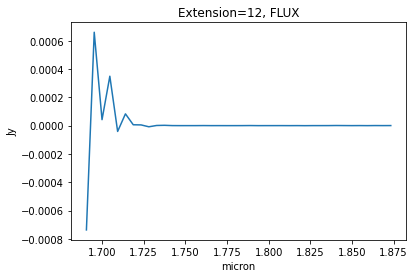

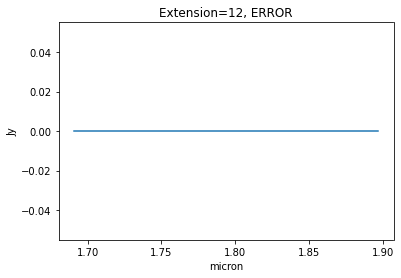

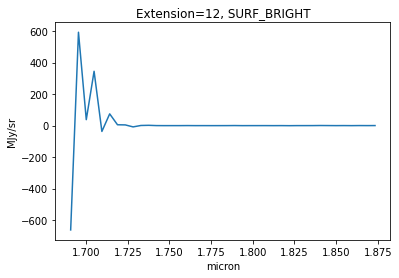

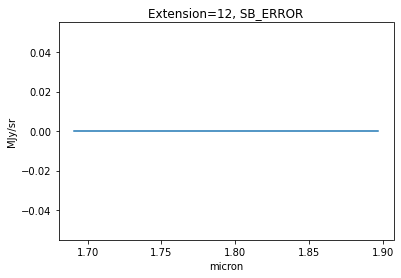

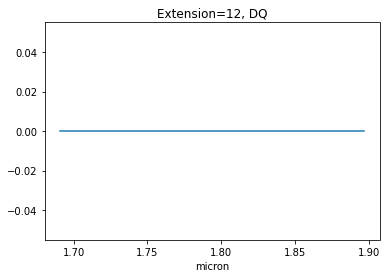

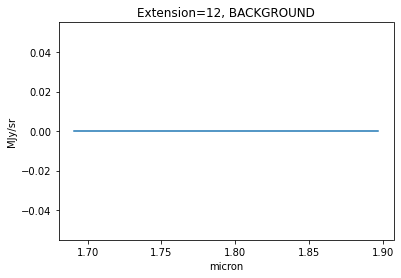

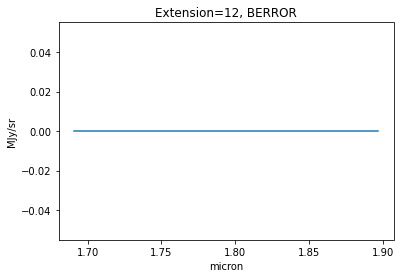

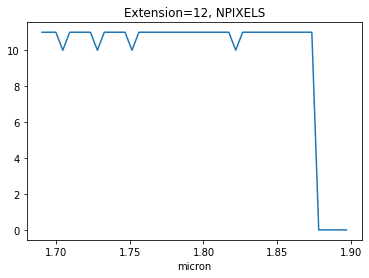

In [72]:
columns = ['WAVELENGTH', 'FLUX', 'ERROR', 'SURF_BRIGHT', 'SB_ERROR', 'DQ', 'BACKGROUND', 'BERROR', 'NPIXELS']
#exts = np.arange(len(gr_1d.spec))
exts = [12]
order = 1
for ext in exts:
    if gr_1d.spec[ext].spectral_order != order:
        print(f"Extension={ext} is not of specified order={order}, aborting")
    else:
        print(f"Extension={ext}")
    for col in columns:        
        print(f"{col}: {gr_1d.spec[ext].spec_table[col]}")
        unit = gr_1d.spec[ext].spec_table.columns[col].unit
        if col != "WAVELENGTH":
            fig, ax = plt.subplots(1)
            ax.plot(gr_1d.spec[ext].spec_table['WAVELENGTH'], gr_1d.spec[ext].spec_table[col])
            ax.set_title(f"Extension={ext}, {col}")
            ax.set_xlabel("micron")
            ax.set_ylabel(unit)
    print("")

In [110]:
np.shape(gr_photom.slits[12].wavelength)

(45, 11)

<a id="inspection1"></a>
# Visually inspect diagnostic arrays and plots above
Do they look appropriate?

[Top of Page](#title_ID)

### Now manually estimate the flux and compare to the pipeline product

In [124]:
pixar_sr = gr_photom.slits[ext].meta.photometry.pixelarea_steradians
leng = gr_1d.spec[ext].spec_table['WAVELENGTH'].shape[0]
wave_1d_man = np.zeros(leng, 'float32')
flux_1d_man = np.zeros(leng, 'float32')

for i in range(leng):
    flux_1d_man[i] = np.sum(gr_photom.slits[ext].data[i,:]) * pixar_sr * 1e6
    wave_1d_man[i] = np.median(gr_photom.slits[ext].wavelength[i,:])

2021-04-25 20:23:52,891 - stpipe - WARNING - /Users/jotaylor/miniconda3/envs/jwstdev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



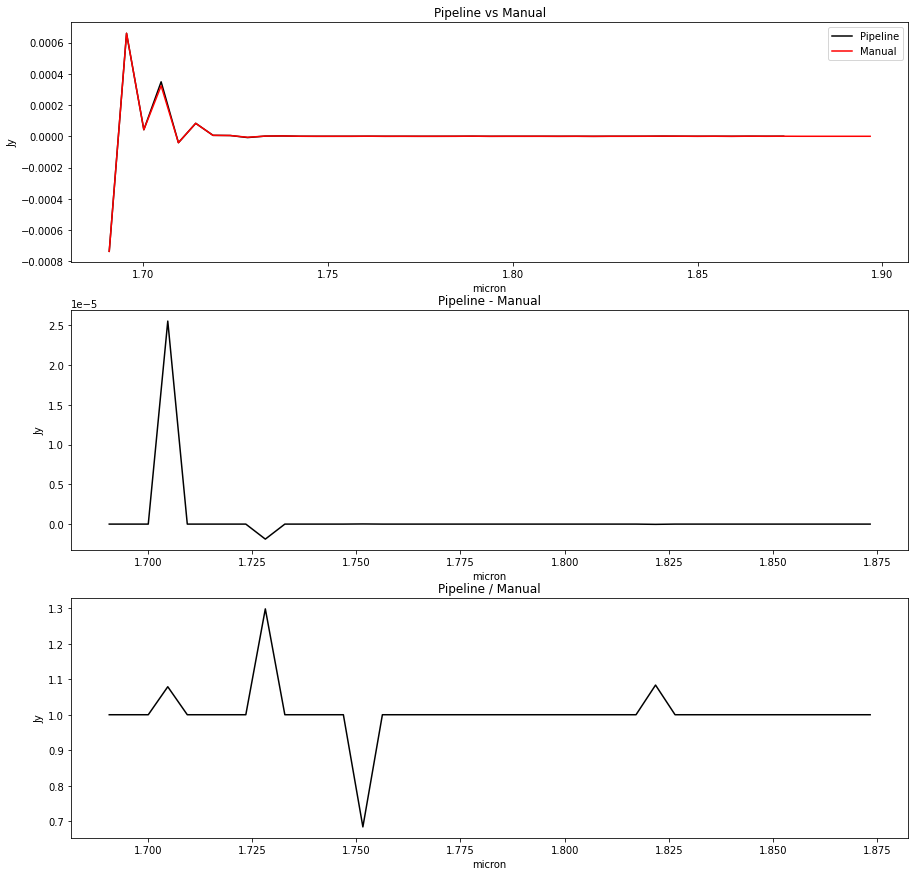

In [125]:
fig, axes = plt.subplots(3,1, figsize=(15, 15))
wave_1d_pipe = gr_1d.spec[ext].spec_table['WAVELENGTH']
flux_1d_pipe = gr_1d.spec[ext].spec_table['FLUX']
axes[0].plot(wave_1d_pipe, flux_1d_pipe, color='k', label='Pipeline')
axes[0].plot(wave_1d_man, flux_1d_man, color='r', label='Manual')
axes[0].set_title("Pipeline vs Manual")
axes[0].legend(loc="best")


axes[1].plot(wave_1d_pipe, flux_1d_pipe-flux_1d_man, color='k', label='Pipeline')
axes[1].set_title("Pipeline - Manual")

axes[2].plot(wave_1d_pipe, flux_1d_pipe/flux_1d_man, color='k', label='Pipeline')
axes[2].set_title("Pipeline / Manual")

unit = gr_1d.spec[ext].spec_table.columns['FLUX'].unit
for ax in axes:
    ax.set_ylabel(unit)
    ax.set_xlabel("micron")

<a id="inspection2"></a>
# Visually inspect comparison plots above
Do they look appropriate?

[Top of Page](#title_ID)

<a id="about_ID"></a>
## About this Notebook
**Authors:** Takahiro Morishita, Jo Taylor
<br>**Updated On:** April 26, 2021

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 